In [1]:
!pip install aiapy 
!pip install numpydoc 

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 5.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.2/210.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 84.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=79ee0bb84af67cbe5877514742ffdfda6b936c37d92524949378b9dd0aa962ed
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
   ━━━━━━━━━━━━━━━

Загрузка датасета и распаковка:


In [2]:
!wget https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
!unzip sunspot_dataset.zip 

--2024-06-02 18:52:14--  https://github.com/observethesun/sunspot_groups/raw/main/dataset/sunspot_dataset.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/observethesun/sunspot_groups/main/dataset/sunspot_dataset.zip [following]
--2024-06-02 18:52:15--  https://raw.githubusercontent.com/observethesun/sunspot_groups/main/dataset/sunspot_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14406615 (14M) [application/zip]
Saving to: 'sunspot_dataset.zip'

sunspot_dataset.zip 100%[===================>]  13.74M  38.6MB/s    in 0.4s    

2024-06-02 18:52:16 (38.6 MB/s) - 'sunspot_dataset.

In [3]:
#!git clone https://github.com/observethesun/helio.git

In [4]:
import git
git.Repo.clone_from('https://github.com/observethesun/helio.git', '/kaggle/working/module_helio')

<git.repo.base.Repo '/kaggle/working/module_helio/.git'>

In [5]:
import os
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import torch
import torch.optim as optim
import torchvision.models as models

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from tqdm import tqdm

import sys
sys.path.append('/kaggle/working/module_helio')

from helio import FilesIndex, HelioBatch, BatchSampler
from helio import VAE

2024-06-02 18:52:33.581614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 18:52:33.581756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 18:52:33.728337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Определяем модель вариационного автоэнкодера с использованием класса VAE из библиотеки helio. Модель VAE имеет входной канал 1, а уровни кодера и декодера имеют размеры фильтров [16, 24, 32, 64] и [48, 32, 24, 16] соответственно. Размерность скрытого пространства установлена равной 16. Выходной слой декодера имеет канал «c» и размер фильтра 1. Модель использует нормализацию.

In [7]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16],
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)

Для расчета потерь восприятия нам также понадобится предварительно обученная модель VGG11. Следуя рекомендациям к модели VGG11, определяем тензоры среднего и стандартного отклонения.

In [8]:
vgg = models.vgg11(pretrained=True)
dis = vgg.features.to(device)
vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:28<00:00, 18.7MB/s]   


Индексируем файлы в наборе данных изображений группы солнечных пятен и сортируем:

In [7]:
itrain = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()
itrain.head()

,img
FilesIndex,
201007230452_63,/kaggle/working/sunspot_dataset/201007230452_6...
201007240414_63,/kaggle/working/sunspot_dataset/201007240414_6...
201007250447_63,/kaggle/working/sunspot_dataset/201007250447_6...
201007250447_64,/kaggle/working/sunspot_dataset/201007250447_6...
201007260349_63,/kaggle/working/sunspot_dataset/201007260349_6...


Настраиваем оптимизатор:

In [11]:
optimizer_ae = optim.Adam(net.parameters(), lr=0.001)

Определяем функцию, измеряющую расхождение Кульбака-Лейблера.  
Определяем batch sampler.  
Определяем функцию для преобразования 3-канальных бинарных масок в одноканальное изображение.

In [9]:
def loss_kl(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())



sampler = BatchSampler(itrain, n_epochs=50, batch_size=64,
                       shuffle=True, drop_incomplete=True)


In [8]:
def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

Производим обучение модели VAE. Вычисляем:

*   потери при восстановлении (loss1) с использованием пиксельной (MSE),
*   потери восприятие (loss2) с помощью модели дискриминатора (dis),
*   потери Кульбака-Лейблера (loss3)
*   итоговые потери (loss)
Производим оптимизацию.


In [14]:
net = net.train()
dis = dis.eval()

loss_hist = []
t = tqdm(sampler)

for ids in t:
    #Load data
    batch = (HelioBatch(ids)
             .load('img', sparse=True)
             .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
             .apply(transform_channels, src='img'))

    #Convert arrays to torch tensors
    x = torch.tensor(np.stack(batch.img)).to(device)

    #Run the VAE model
    out, mu, logvar = net(x)

    #Reconstruction loss (pixel-wise MSE)
    loss1 = ((x - out)**2).mean()

    #Data preparation for the perceptual loss
    x3 = torch.cat([x, x, x], dim=1)
    out3 = torch.cat([out, out, out], dim=1)

    fx = dis((x3 - vgg_mean) / vgg_std)
    fout = dis((out3 - vgg_mean) / vgg_std)

    #Perceptual loss
    loss2 = ((fx - fout)**2).mean()

    #Kullback-Leibler loss
    loss3 = loss_kl(mu, logvar)

    #Final loss
    loss = 100*loss1 + loss2 + loss3

    loss_hist.append([loss1.item(), loss2.item(), loss3.item()])
    t.set_description("Loss rec {:.4f} dis {:.4f} kl {:.4f}"
                      .format(loss1.item(), loss2.item(), loss3.item()))

    #Make optimization step
    optimizer_ae.zero_grad()
    loss.backward()
    optimizer_ae.step()

  0%|          | 0/6600 [00:02<?, ?it/s]


KeyboardInterrupt: 

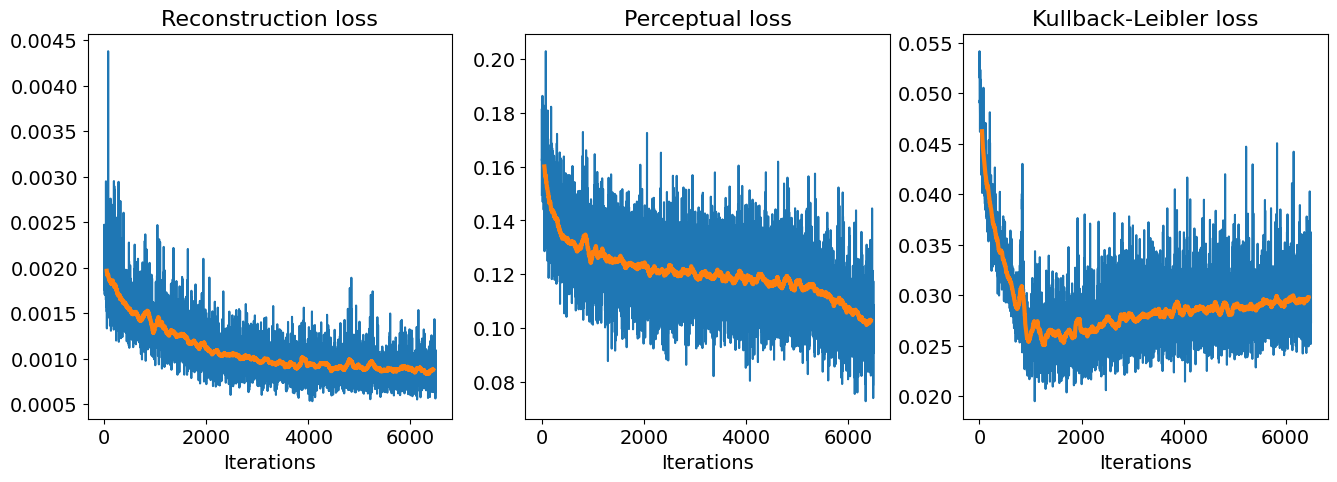

In [12]:
skip = 100
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
fig.patch.set_facecolor('xkcd:white')
loss = np.asarray(loss_hist)
for i in range(3):
    ax[i].plot(loss[skip:, i])
    ax[i].plot(pd.DataFrame(loss[skip:, i]).rolling(100, center=True).mean(), lw=3)
    ax[i].set_xlabel('Iterations', fontsize=14)
    ax[i].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Reconstruction loss', fontsize=16)
ax[1].set_title('Perceptual loss', fontsize=16)
ax[2].set_title('Kullback-Leibler loss', fontsize=16)
plt.show()

####Код для сохранения и загрузки модели

In [10]:
# Создание директории для сохранения модели
if not os.path.exists('/kaggle/working/model_dumps'):
    os.makedirs('/kaggle/working/model_dumps')

In [14]:
torch.save(net.state_dict(), '/kaggle/working/model_dumps/vae_vgg11_model')

In [24]:
import git

# URL репозитория GitHub
repo_url = 'https://github.com/mmm8sul/Clustering_sunspot_groups.git'

# Путь к директории, куда нужно скопировать файлы
destination_path = '/kaggle/working/model_dumps'

# Клонирование репозитория
git.Repo.clone_from(repo_url, destination_path)


<git.repo.base.Repo '/kaggle/working/model_dumps/.git'>

In [30]:
net = VAE(in_channels=1,
    filters_enc=[16, 24, 32, 64],
    filters_dec=[48, 32, 24, 16], #48 -> 64
    z_dim=16,
    output=dict(layout='c', filters=1),
    norm=True,
    variational=True).to(device)

net.load_state_dict(torch.load('/kaggle/input/vae/pytorch/vae/1/vae_model (1)'))

index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()


itrain = index
optimizer_ae = optim.Adam(net.parameters(), lr=0.001)

def transform_channels(arr):
    out = (arr[..., 0] | arr[..., 2]).astype(np.float32)
    out[arr[..., 1]] = 2
    return np.expand_dims(out, 0) / 2 #normalize to [0, 1]

####Получаем скрытые векторы с помощью модели VAE:

In [15]:
emb = [] #array of latent vectors
sampler = BatchSampler(itrain, n_epochs=1, batch_size=64,
                       shuffle=False, drop_incomplete=False)

net = net.eval()
with torch.no_grad():
    for ids in tqdm(sampler):
        batch = (HelioBatch(ids)
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)
        y = net.encode(x)
        #print(x.shape) # torch.Size([64, 1, 256, 256])
        #print(y.shape) # torch.Size([64, 16, 16, 16])
        
        emb.append(y.detach().cpu().numpy().reshape(y.shape[0], -1))
emb = np.vstack(emb)

100%|██████████| 133/133 [00:32<00:00,  4.11it/s]


In [16]:
type(emb)

numpy.ndarray

In [17]:
with open('numpy logo.npy', 'wb') as vae_vgg11_emb:
      np.save(vae_vgg11_emb, emb)

In [10]:
# распаковка эмбедингов
with open('/kaggle/input/vae-vgg-emb/numpy logo.npy', 'rb') as vae_vgg11_emb:
      emb = np.load(vae_vgg11_emb)

In [11]:
emb.shape

(8498, 4096)

In [14]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# emb = scaler.fit_transform(emb)
# emb.shape

(8498, 4096)

#Hierarchical clustering

Выполним иерархическую кластеризацию используя алгоритм минимизации Уорда.  
Построим дендрограмму.

In [12]:
hier_clust = linkage(emb, method='ward')

In [14]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c,coph_dists = cophenet(hier_clust,pdist(emb))
c

0.9542901424612245

In [15]:
# Список методов для иерархической кластеризации
methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median','ward']

best_cophenet_corr = 0
best_method = None

for method in methods:
    hier_clust = linkage(emb, method=method)
    c, coph_dists = cophenet(hier_clust, pdist(emb))
    print(method, c)
    print(f"Коэффициент кофенетической корреляции: {c} при использовании метода {method}")
    if c > best_cophenet_corr:
        best_cophenet_corr = c
        best_method = method
    
print(f"Лучший коэффициент кофенетической корреляции: {best_cophenet_corr} при использовании метода {best_method}")

single 0.9542901424612245
Коэффициент кофенетической корреляции: 0.9542901424612245 при использовании метода single
complete 0.7648082363381311
Коэффициент кофенетической корреляции: 0.7648082363381311 при использовании метода complete
average 0.9663781779550178
Коэффициент кофенетической корреляции: 0.9663781779550178 при использовании метода average
weighted 0.8469139358123592
Коэффициент кофенетической корреляции: 0.8469139358123592 при использовании метода weighted
centroid 0.952882123432376
Коэффициент кофенетической корреляции: 0.952882123432376 при использовании метода centroid
median 0.9336096888044093
Коэффициент кофенетической корреляции: 0.9336096888044093 при использовании метода median
ward 0.1780848171534022
Коэффициент кофенетической корреляции: 0.1780848171534022 при использовании метода ward
Лучший коэффициент кофенетической корреляции: 0.9663781779550178 при использовании метода average


In [68]:
for t in range(round(max(distances))):
    labels_1 = fcluster(hier_clust_2, t=t, criterion='distance')
    #print(set(labels_1))
    if len(set(labels_1)) == 7:
        break
print(t)

31


In [15]:
labels_1 = fcluster(hier_clust, t=distances_sorted[6]+0.01, criterion='distance')
len(set(labels_1))

NameError: name 'distances_sorted' is not defined

In [59]:
set(labels_1)

{1, 2, 3, 4, 5, 6, 7}

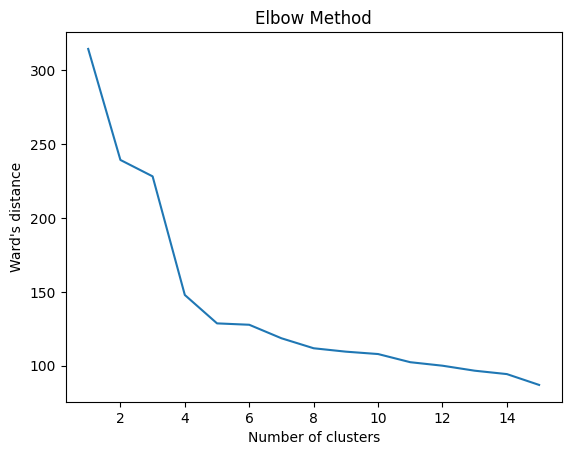

In [16]:
# получаем список последних 15 значений расстояний между кластерами при их слиянии
distances = hier_clust[-15:, 2]

# сортируем список расстояний в порядке убывания
distances_sorted = sorted(distances, reverse=True)

#plt.figure(figsize=(10, 7))
plt.plot(range(1, len(distances_sorted) + 1), distances_sorted)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Ward's distance")
plt.show()

In [17]:
for t in range(round(max(distances_sorted))):
    labels_1 = fcluster(hier_clust, t=t, criterion='distance')
    if len(set(labels_1)) == 7:
        break
print(t)

119


Количество уникальных меток (кластеров):

In [18]:
set(labels_1) 

{1, 2, 3, 4, 5, 6, 7}

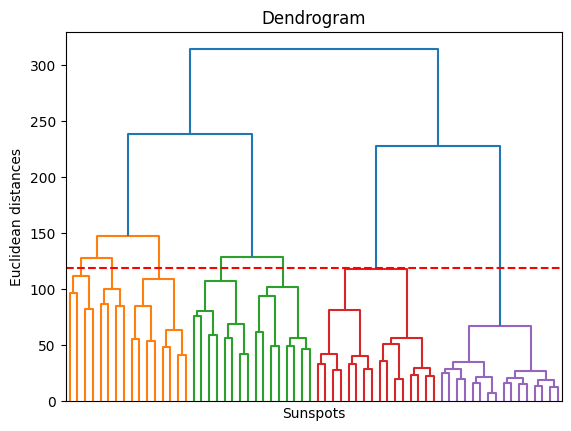

In [19]:
dendrogram(
            hier_clust,
            truncate_mode='level',
            p=5,
            orientation='top',
            distance_sort='descending',
            no_labels=True)

plt.title('Dendrogram')
plt.xlabel('Sunspots')
plt.ylabel('Euclidean distances')
plt.axhline(y=t, color='red', linestyle='--')
plt.show()

На основе дендрограммы разделим данные на 7 кластеров:

In [20]:
# Добавляем в словарь изображения на основе их меток:
import random

clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
for index, label in enumerate(labels_1):
    #print('img:',index, 'label:',label)
    for i in range(1, 8):
        if label == i:
            clusters[i].append(index)

In [21]:
set(labels_1)

{1, 2, 3, 4, 5, 6, 7}

In [22]:
for cluster_num, indices in clusters.items():
    print(indices[:5])
    #sampled_clusters[cluster_num] = indices[:4] #random.choices(indices, k=5)

[3, 5, 24, 26, 30]
[8, 9, 12, 14, 16]
[90, 95, 137, 140, 142]
[0, 10, 11, 13, 25]
[1, 2, 4, 7, 38]
[6, 15, 17, 20, 21]
[18, 23, 27, 29, 34]


In [23]:
# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
for cluster_num, indices in clusters.items():
    #print(f"Кластер {cluster_num}: {indices}")
    sampled_clusters[cluster_num] = indices[:5] #random.choices(indices, k=5)
    print(f"Кластер {cluster_num}. Элементов: {len(indices)}: {sampled_clusters[cluster_num]}")
    num_clusts.append(len(indices))

Кластер 1. Элементов: 1878: [3, 5, 24, 26, 30]
Кластер 2. Элементов: 1264: [8, 9, 12, 14, 16]
Кластер 3. Элементов: 519: [90, 95, 137, 140, 142]
Кластер 4. Элементов: 854: [0, 10, 11, 13, 25]
Кластер 5. Элементов: 1045: [1, 2, 4, 7, 38]
Кластер 6. Элементов: 1339: [6, 15, 17, 20, 21]
Кластер 7. Элементов: 1599: [18, 23, 27, 29, 34]


In [24]:
x = 0 # проверка, что не забыли изображения
for i in range(len(num_clusts)):
    x = x + num_clusts[i]
print(x)

8498


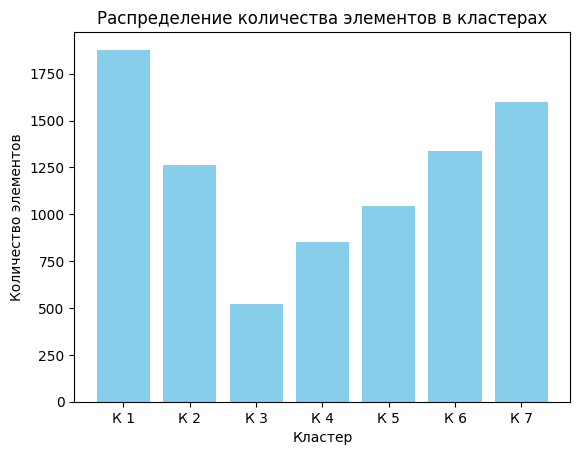

In [25]:
plt.bar(range(len(num_clusts)), num_clusts, color='skyblue')
plt.xlabel('Кластер')
plt.ylabel('Количество элементов')
plt.title('Распределение количества элементов в кластерах')
plt.xticks(range(len(num_clusts)), [f'К {i+1}' for i in range(len(num_clusts))])
plt.show()

In [30]:
def plot_tsne_with_iterations(emb, labels_1, iterations, perplexity):
    plt.figure(figsize=(15, 12))
    for i in range(iterations):
        tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity, n_iter=(i+1)*250)
        emb_tsne = tsne.fit_transform(emb)
        plt.subplot(2, 2, i+1)
        plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=labels_1, cmap='viridis')
        plt.title(f'Iteration {(i+1)*250}')
    plt.tight_layout()
    plt.show()

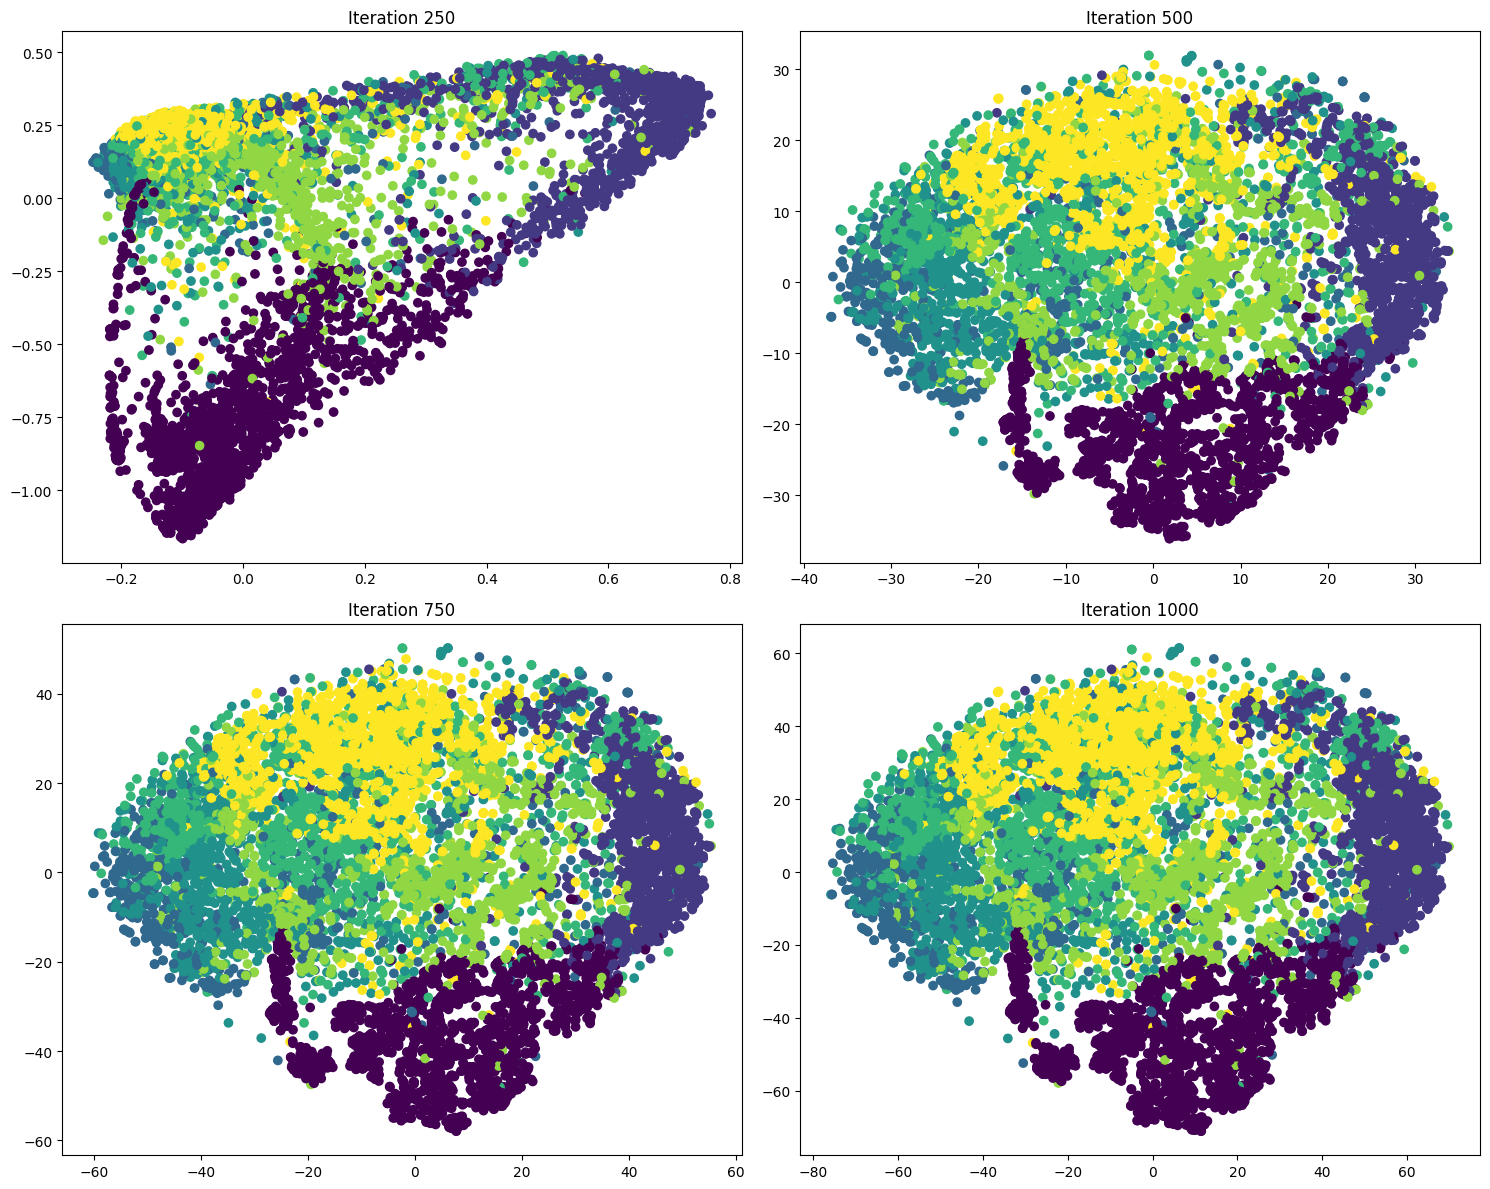

In [31]:
plot_tsne_with_iterations(emb, labels_1, iterations=4, perplexity=30)

In [24]:
tsne=TSNE(n_components=2, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [25]:
fig = px.scatter(
    emb_tsne, x=0, y=1,
    labels={'color': 'species'},
    color=labels_1
)
fig.update_traces(marker_size=5)
fig.show()

In [27]:
tsne=TSNE(n_components=2, early_exaggeration=100.0, random_state=0)
emb_tsne = tsne.fit_transform(emb)
fig = px.scatter(
    emb_tsne, x=0, y=1,
    labels={'color': 'species'},
    color=labels_1
)
fig.update_traces(marker_size=5)
fig.show()

В пространстве размерности 3:

In [58]:
tsne=TSNE(n_components=3, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [59]:
fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_1,
        colorscale='turbo',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()

In [60]:
index = FilesIndex(path='/kaggle/working/sunspot_dataset/*.npz', name='img').sort_index()

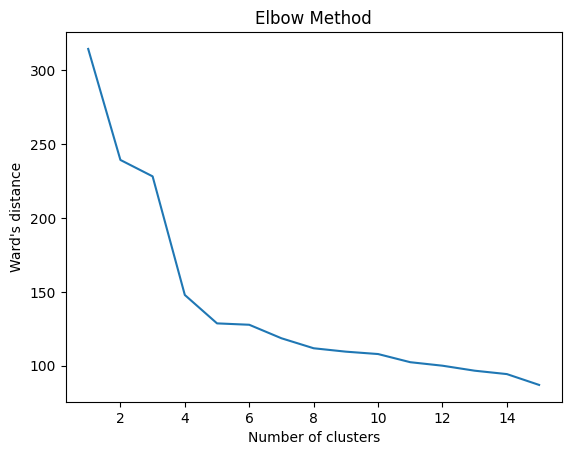

In [11]:
hier_clust = linkage(emb, method='ward')

# получаем список последних 15 значений расстояний между кластерами при их слиянии
distances = hier_clust[-15:, 2]

# сортируем список расстояний в порядке убывания
distances_sorted = sorted(distances, reverse=True)

#plt.figure(figsize=(10, 7))
plt.plot(range(1, len(distances_sorted) + 1), distances_sorted)
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Ward's distance")
plt.show()

In [15]:
# for t in range(round(max(distances))):
#     labels_1 = fcluster(hier_clust, t=t, criterion='distance')
#     #print(set(labels_1))
#     if len(set(labels_1)) == 7:
#         break
# print(t)
labels_1 = fcluster(hier_clust, t=distances_sorted[5], criterion='distance')
len(set(labels_1))

6

In [75]:
import random

Кластер 1. Элементов: 1878: [3, 5, 24, 26, 30]
Кластер 2. Элементов: 1264: [8, 9, 12, 14, 16]
Кластер 3. Элементов: 519: [90, 95, 137, 140, 142]
Кластер 4. Элементов: 854: [0, 10, 11, 13, 25]
Кластер 5. Элементов: 1045: [1, 2, 4, 7, 38]
Кластер 6. Элементов: 2938: [6, 15, 17, 18, 20]


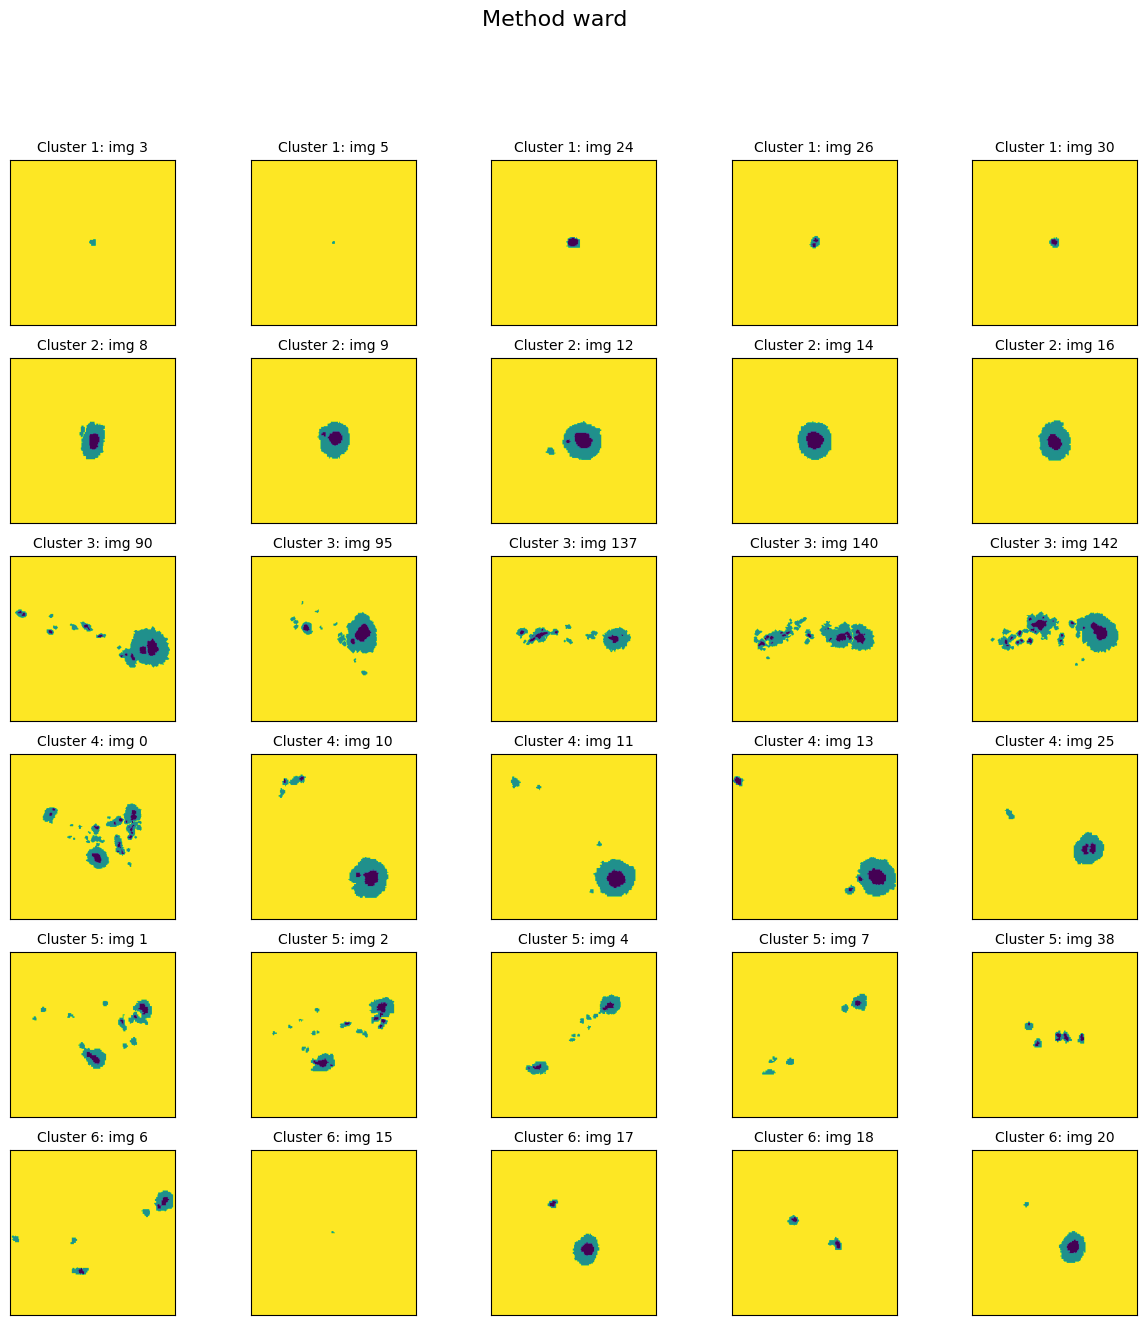

In [126]:


# Добавляем в словарь изображения на основе их меток:
import random

clusters = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for index, label in enumerate(labels_1):
    #print('img:',index, 'label:',label)
    for i in range(1, 7):
        if label == i:
            clusters[i].append(index)

# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
for cluster_num, indices in clusters.items():
    #print(f"Кластер {cluster_num}: {indices}")
    sampled_clusters[cluster_num] = indices[0:5] #random.choices(indices, k=5)
    print(f"Кластер {cluster_num}. Элементов: {len(indices)}: {sampled_clusters[cluster_num]}")
    num_clusts.append(len(indices))

fig, ax = plt.subplots(6, len(sampled_clusters[1]), figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

#for i, color_clust in enumerate([light_green_clust, yellow_clust, green_clust, turquoise_clust, blue_clust,light_blue_clust,purple_clust]):
for i, (key, color_clust) in enumerate(sampled_clusters.items()):    
    with torch.no_grad():
        batch = (HelioBatch(itrain.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
plt.suptitle('Method ward',fontsize=16)
plt.show()

In [30]:
labels_20 = fcluster(hier_clust, t=distances_sorted[6], criterion='distance')
len(set(labels_20))

7

In [47]:
len(np.unique(labels_20))

7

In [48]:
from sklearn.metrics import pairwise_distances

def inter_cluster_distance(X, labels):
    n_clusters = len(np.unique(labels))
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(1,1+ n_clusters)])
    return np.mean(pairwise_distances(centroids, metric='euclidean'))

# Пример использования
inter_cluster_dist = inter_cluster_distance(emb, labels_20)
print("Среднее межкластерное расстояние:", inter_cluster_dist)

Среднее межкластерное расстояние: 5.309021


5
Кластер 1. Элементов: 1878: [5693, 4577, 3196, 5080, 7973]
Кластер 2. Элементов: 1264: [8139, 8003, 6305, 559, 5885]
Кластер 3. Элементов: 1373: [7037, 4641, 5265, 2162, 2922]
Кластер 4. Элементов: 1045: [4197, 2547, 3436, 2399, 6667]
Кластер 5. Элементов: 2938: [4010, 2264, 5050, 8432, 4062]


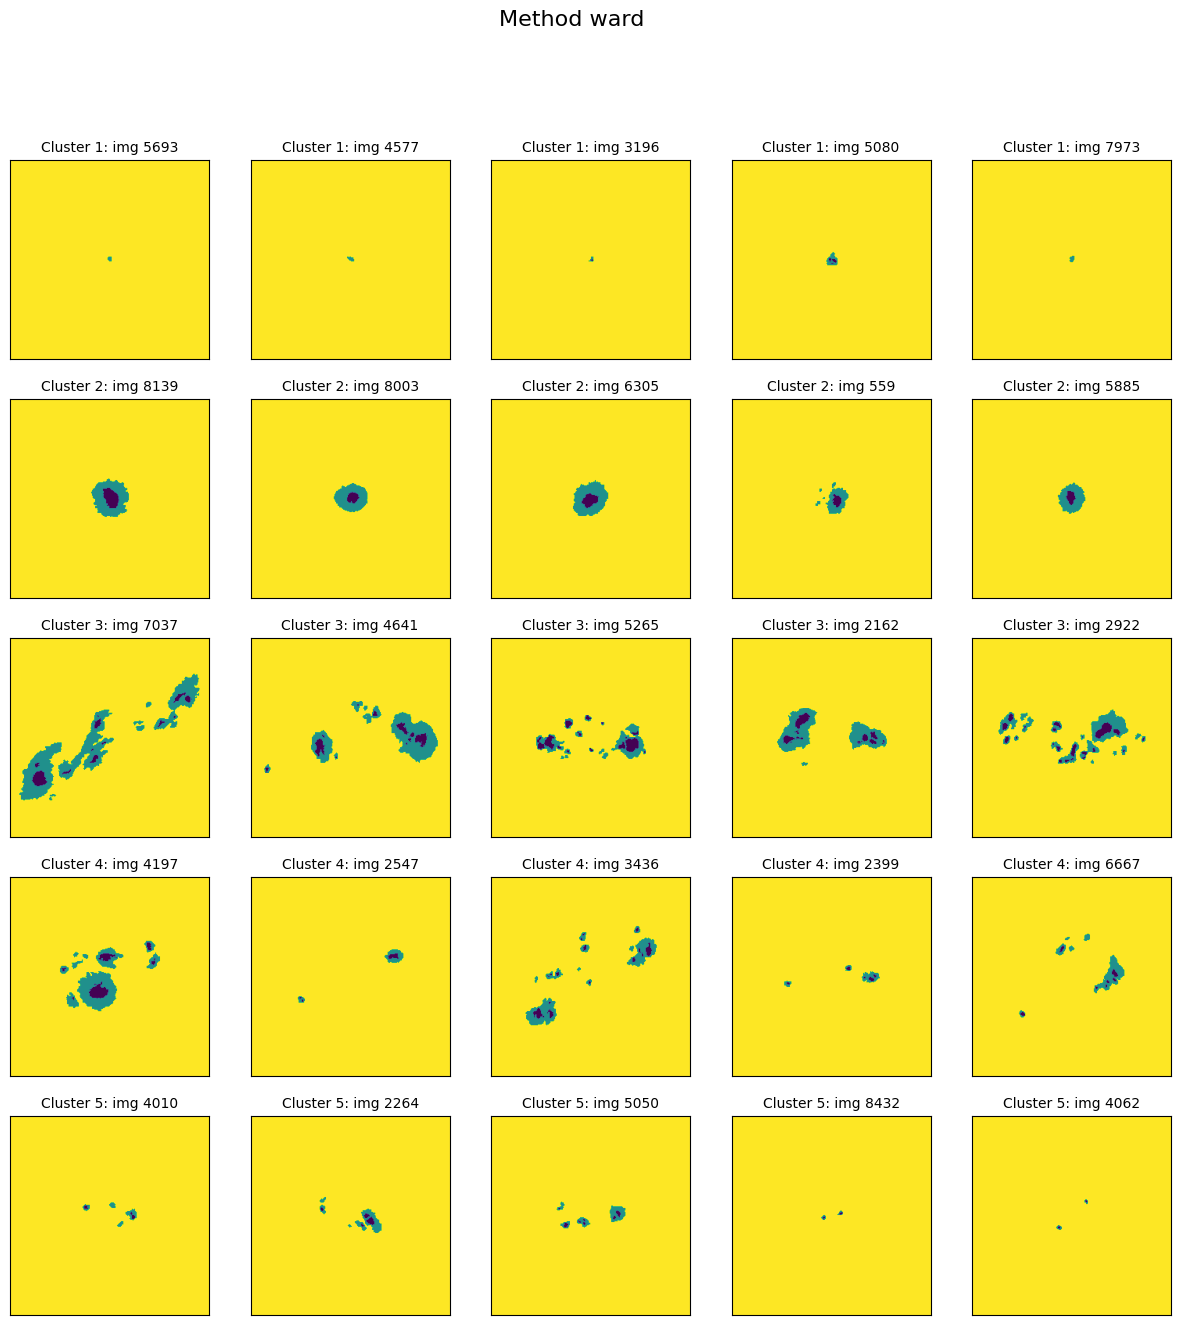

In [21]:
labels_11 = fcluster(hier_clust, t=distances_sorted[4], criterion='distance')
print(len(set(labels_11)))

# Добавляем в словарь изображения на основе их меток:
import random

clusters = {1: [], 2: [], 3: [], 4: [], 5: []}
for index, label in enumerate(labels_11):
    #print('img:',index, 'label:',label)
    for i in range(1, 7):
        if label == i:
            clusters[i].append(index)

# выбираем случайным образом по 5 точек в каждый кластер
num_clusts = []
sampled_clusters = {}
for cluster_num, indices in clusters.items():
    #print(f"Кластер {cluster_num}: {indices}")
    sampled_clusters[cluster_num] = random.choices(indices, k=5)
    print(f"Кластер {cluster_num}. Элементов: {len(indices)}: {sampled_clusters[cluster_num]}")
    num_clusts.append(len(indices))

fig, ax = plt.subplots(5, len(sampled_clusters[1]), figsize=(15, 15))
fig.patch.set_facecolor('xkcd:white')

for i, (key, color_clust) in enumerate(sampled_clusters.items()):    
    with torch.no_grad():
        batch = (HelioBatch(itrain.iloc[color_clust])
                 .load('img', sparse=True)
                 .apply(lambda x: x.toarray().reshape(256, 256, 3), src='img')
                 .apply(transform_channels, src='img'))
        x = torch.tensor(np.stack(batch.img)).to(device)

    for j in range(len(sampled_clusters[1])):
        ax[i][j].imshow(1-x[j,0].detach().cpu().numpy(),vmin=0, vmax=1)
        ax[i][j].set_title('Cluster {}: img {}'.format(key, color_clust[j]), fontsize=10)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
plt.suptitle('Method ward',fontsize=16)
plt.show()

In [75]:
sampled_clusters.items()

dict_items([(1, [5049, 5906, 8332, 7501, 4929]), (2, [7324, 125, 6541, 6868, 5312]), (3, [471, 5221, 140, 6489, 6475]), (4, [3271, 3156, 3618, 3405, 4951]), (5, [908, 4094, 955, 5425, 6827]), (6, [5225, 7549, 7009, 5619, 2383]), (7, [7887, 530, 1130, 5565, 2236])])

In [77]:
for i, (key, cluster) in enumerate(sampled_clusters.items()):
    print("i", i,"key", key, 'clust',cluster)

i 0 key 1 clust [5049, 5906, 8332, 7501, 4929]
i 1 key 2 clust [7324, 125, 6541, 6868, 5312]
i 2 key 3 clust [471, 5221, 140, 6489, 6475]
i 3 key 4 clust [3271, 3156, 3618, 3405, 4951]
i 4 key 5 clust [908, 4094, 955, 5425, 6827]
i 5 key 6 clust [5225, 7549, 7009, 5619, 2383]
i 6 key 7 clust [7887, 530, 1130, 5565, 2236]


In [ ]:
for i, (key, cluster) in enumerate(sampled_clusters.items()):
    print("i", i,"key", key, 'clust',cluster)

In [25]:
tsne=TSNE(n_components=3, random_state=0, perplexity=50)
emb_tsne = tsne.fit_transform(emb)

fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_1,
        colorscale='turbo',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()

###Представим 6 кластерных структур

В пространстве размерности 2:

In [ ]:
tsne=TSNE(n_components=2, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [ ]:
fig = px.scatter(
    emb_tsne, x=0, y=1,
    labels={'color': 'species'},
    color=labels_2
)
fig.update_traces(marker_size=5)
fig.show()

В пространстве размерности 3:

In [ ]:
tsne=TSNE(n_components=3, perplexity=30, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_2,
        colorscale='Viridis',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()

In [ ]:
tsne=TSNE(n_components=3, perplexity=40, random_state=0)
emb_tsne = tsne.fit_transform(emb)

In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=emb_tsne[:, 0],
    y=emb_tsne[:, 1],
    z=emb_tsne[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=labels_2,
        colorscale='Viridis',
        opacity=0.8
    ),
    hovertext=['Image #' + str(i) for i in range(len(emb_tsne))],
    hoverinfo='text'
)])

fig.show()

# Rotation invariant VAE properties



In [40]:
inv_emb = pd.read_csv('/kaggle/input/inv-emb/properties_embeddings.csv')
inv_emb.head(3)

,fname,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,...,22,23,24,25,26,27,28,29,30,31
0,201007230452_63,2010-07-23 04:52:00,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,...,1.324323,0.206686,-0.773984,-0.706433,-2.542088,0.735927,-1.828404,-0.400432,1.794184,3.556576
1,201007240414_63,2010-07-24 04:14:00,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,...,-2.280273,0.033423,0.763244,-1.771013,-2.397232,-2.849603,1.879758,0.610913,2.046473,0.696940
2,201007250447_64,2010-07-25 04:47:00,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,...,0.882444,-1.093549,-4.075765,-1.007012,-0.632858,-1.608380,3.260197,-3.865491,-2.199181,0.908257


In [41]:
inv_emb = pd.read_csv('/kaggle/input/inv-emb/properties_embeddings.csv')
df_a = inv_emb.iloc[:,:1]
df_b = inv_emb.iloc[:,17:]
inv_emb = pd.concat([df_a,df_b], axis=1)
inv_emb.head()

,fname,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,201007230452_63,-2.548106,1.181495,1.375547,-0.209886,-0.436301,0.058469,-2.751680,0.625120,1.801969,...,1.324323,0.206686,-0.773984,-0.706433,-2.542088,0.735927,-1.828404,-0.400432,1.794184,3.556576
1,201007240414_63,3.308705,1.701356,1.008363,-1.859264,2.262855,0.689745,-2.013217,1.596452,1.904591,...,-2.280273,0.033423,0.763244,-1.771013,-2.397232,-2.849603,1.879758,0.610913,2.046473,0.696940
2,201007250447_64,0.544050,3.871653,-3.011444,1.899010,1.585517,0.991888,0.255717,0.413672,2.141736,...,0.882444,-1.093549,-4.075765,-1.007012,-0.632858,-1.608380,3.260197,-3.865491,-2.199181,0.908257
3,201007250447_63,-1.362825,-0.010082,0.880551,-1.187509,1.229160,0.494770,0.262265,-0.863415,0.337300,...,0.853395,-0.443927,0.792002,0.817088,-1.461736,1.366083,0.501775,0.562915,0.865622,-0.038163
4,201007260349_63,-0.046227,1.317150,-0.152698,2.753534,0.559023,2.216889,0.822927,1.570466,1.517516,...,-0.926250,-1.676673,-0.953451,-1.084468,-0.894734,-2.140663,0.451901,-0.782241,-1.185347,1.115910


In [42]:
fnames = inv_emb['fname'].tolist()

In [43]:
len(fnames)

8498

In [44]:
type(inv_emb)

pandas.core.frame.DataFrame

In [45]:
inv_emb.sort_values('fname')
None

In [46]:
inv_emb = inv_emb.iloc[:,1:]
#inv_emb = inv_emb.to_numpy()

In [47]:
inv_emb.shape

(8498, 32)

In [95]:
pca = PCA(0.95)
inv_emb_pca = pca.fit_transform(inv_emb)

In [62]:
pca = PCA(n_components=3)
inv_emb_pca = pca.fit_transform(inv_emb)

In [172]:
variance_percent = pca.explained_variance_ratio_

In [174]:
total_variance_percent = sum(variance_percent)
total_variance_percent

0.47369736754877856

In [49]:
pca.n_components_

2

In [63]:
inv_emb_pca.shape

(8498, 3)

In [64]:
with torch.no_grad():
    rmu = pca.transform(inv_emb)
    irmu = pca.inverse_transform(rmu).reshape(inv_emb.shape)

In [65]:
rmu.shape, irmu.shape

((8498, 3), (8498, 32))

In [66]:
pca.n_components_

3

In [67]:
dfp = pd.read_csv('/kaggle/input/sunspot-group-properties/sunspot_group_properties.csv').set_index('fname')
dfp.head(3)

,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0
fname,,,,,,,,,,,,,,,,
201007230452_63,2010-07-23 04:52:00,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,17,16,6,-2.385188,210,5.0,230.3
201007240414_63,2010-07-24 04:14:00,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,9,4,3,-23.918642,241,5.1,217.4
201007250447_64,2010-07-25 04:47:00,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,1,0,0,3.633730,78,5.2,203.9


In [68]:
rmu.shape

(8498, 3)

In [69]:
df_values = pd.DataFrame(rmu).set_index([fnames])
df_values.index.name = 'fname'

In [70]:
df_values

,0,1,2
fname,,,
201007230452_63,6.722098,-3.372014,2.014297
201007240414_63,4.168529,-6.150626,-3.944034
201007250447_64,-7.023851,-0.066710,0.302950
201007250447_63,4.547608,-4.136499,1.298764
201007260349_63,2.408196,-3.020288,2.007528
...,...,...,...
202008120532_31,-6.190829,-1.660586,0.670244
202008120532_33,-5.304951,-2.274691,-0.110792
202008180351_34,-7.045451,-0.322938,0.091712


In [183]:
df = dfp.join(df_values)
df.head()

,date,group_number,lat_max,lat_mean,lat_min,long_max,long_mean,long_min,area,nspots,ncores,nspots_with_cores,tilt,complexity,B0,L0,0,1
fname,,,,,,,,,,,,,,,,,,
201007230452_63,2010-07-23 04:52:00,63,-20.896839,-23.565131,-26.597699,204.043367,200.328655,194.646751,489.292797,17,16,6,-2.385188,210,5.0,230.3,6.722098,-3.372014
201007240414_63,2010-07-24 04:14:00,63,-21.131845,-23.933526,-27.108871,204.704703,201.274268,194.511357,303.408179,9,4,3,-23.918642,241,5.1,217.4,4.168529,-6.150626
201007250447_64,2010-07-25 04:47:00,64,23.580196,23.339903,23.101008,149.500812,149.048761,148.527835,16.553683,1,0,0,3.633730,78,5.2,203.9,-7.023851,-0.066710
201007250447_63,2010-07-25 04:47:00,63,-20.642013,-23.509269,-26.938974,204.949343,201.557542,195.071475,297.469260,12,7,3,-32.418379,232,5.2,203.9,4.547608,-4.136499
201007260349_63,2010-07-26 03:49:00,63,-20.258757,-23.032369,-26.887540,205.544796,202.530956,198.138547,193.869511,9,3,2,-40.638848,255,5.0,191.2,2.408196,-3.020288


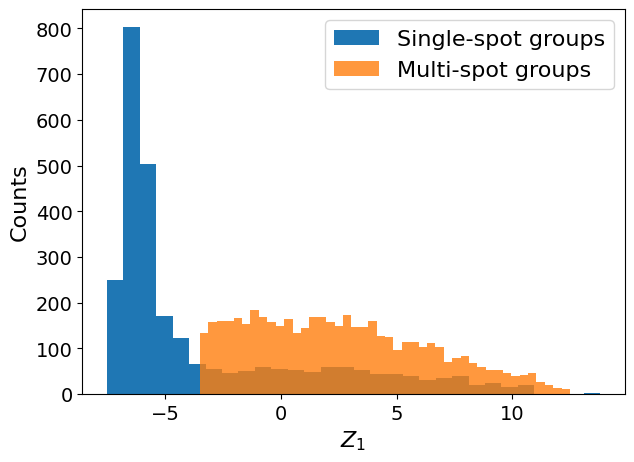

In [184]:
fig, ax = plt.subplots(1, figsize=(7, 5))
fig.patch.set_facecolor('xkcd:white')

mask = (df.nspots == 1)
plt.hist(df.loc[mask,0], bins=30, color='tab:blue', label='Single-spot groups')

mask = (dfp.nspots >= 2)
plt.hist(df.loc[mask, 0], bins=np.linspace(-3.5, 12.5, 45),
         color='tab:orange', alpha=0.8, label='Multi-spot groups')

plt.ylabel('Counts', fontsize=16)
plt.xlabel(r'$Z_1$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

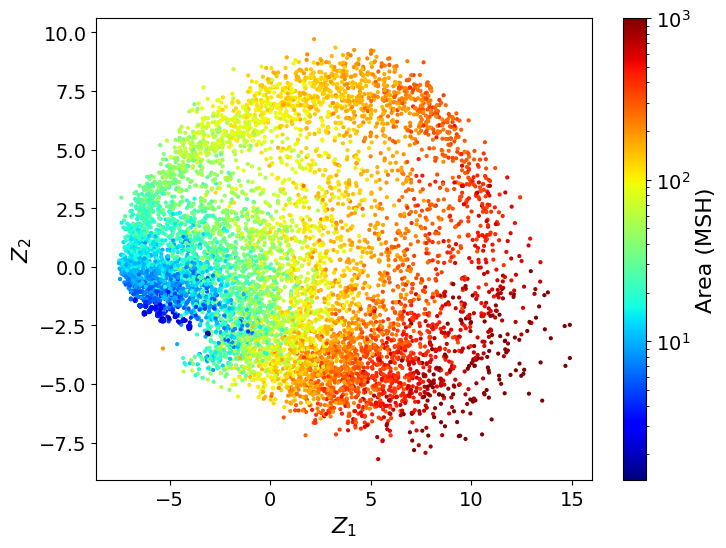

In [185]:
import matplotlib
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.patch.set_facecolor('xkcd:white')

plt.scatter(*df[[0, 1]].values.T, s=4,
            cmap='jet',
            c=np.clip(df.area, 0, 1000),
            norm=matplotlib.colors.LogNorm())

plt.ylabel(r'$Z_2$', fontsize=16)
plt.xlabel(r'$Z_1$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'Area (MSH)', rotation=90, fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.show()